In [14]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = "whitegrid")
import sklearn
from mlxtend.plotting import plot_confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("../../datasets/knn.csv")
data.head()

,age,salary,level
0,30,250000,Level A
1,20,400000,Level A
2,35,300000,Level A
3,24,270000,Level A
4,26,380000,Level A


### Training and Testing data

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:2], data.iloc[:,2], test_size = 0.25, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

11 11 4 4


### Visualization

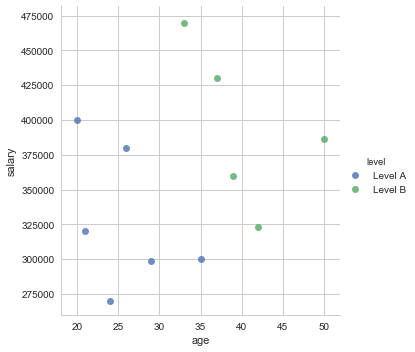

In [4]:
train = pd.DataFrame([X_train.iloc[:,0].reset_index(drop=True), 
                      X_train.iloc[:,1].reset_index(drop=True), 
                      y_train.reset_index(drop=True)]).T
sns.lmplot("age", "salary", data = train, hue='level', fit_reg=False)

### Boxplot

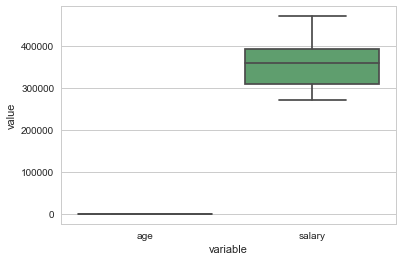

In [5]:
df = pd.melt(train.iloc[:,:2])
df.loc[:,"value"] = df.loc[:,"value"].astype(np.float)
sns.boxplot(df.iloc[:,0], df.iloc[:,1])

### Finding Euclidean distance of a point (age,salary):(29,298500) from rest of the points

In [6]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
print(X_train)  # Target point at index 4

    age  salary
0    21  320000
1    39  360005
2    35  300000
3    20  400000
4    29  298500
5    26  380000
6    37  430000
7    50  386500
8    42  323000
9    24  270000
10   33  470000


In [7]:
# norm accepts argument in form -> sqrt(a^2 + b^2)
[np.round(
    np.linalg.norm(
        pd.Series([29,298500]).sub(
            pd.Series([X_train.iloc[i,0], X_train.iloc[i,1]])))) 
 for i in range(len(X_train))]

[21500.0,
 61505.0,
 1500.0,
 101500.0,
 0.0,
 81500.0,
 131500.0,
 88000.0,
 24500.0,
 28500.0,
 171500.0]

### Normalizing the data

In [8]:
from sklearn.preprocessing import MinMaxScaler
old_train = train.copy()
train.iloc[:,:2] = MinMaxScaler().fit_transform(train.iloc[:,:2])
print(old_train)
train

   age  salary    level
0   21  320000  Level A
1   39  360005  Level B
2   35  300000  Level A
3   20  400000  Level A
4   29  298500  Level A
5   26  380000  Level A
6   37  430000  Level B
7   50  386500  Level B
8   42  323000  Level B
9   24  270000  Level A
10  33  470000  Level B


,age,salary,level
0,0.0333333,0.25,Level A
1,0.633333,0.450025,Level B
2,0.5,0.15,Level A
3,0,0.65,Level A
4,0.3,0.1425,Level A
5,0.2,0.55,Level A
6,0.566667,0.8,Level B
7,1,0.5825,Level B
8,0.733333,0.265,Level B
9,0.133333,0,Level A


### Verifying structure after normalizing data

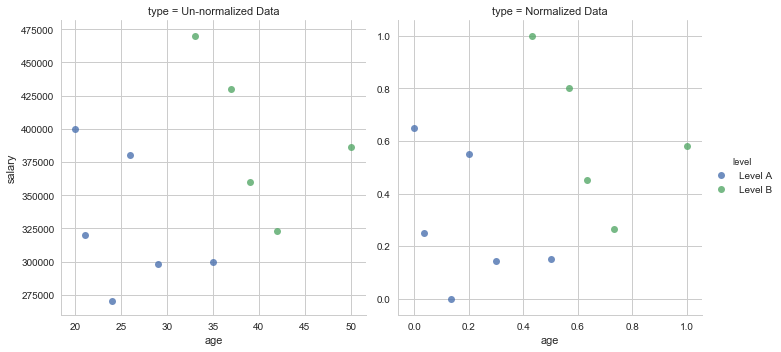

In [9]:
old_train["type"] = "Un-normalized Data"
train["type"] = "Normalized Data"
df = pd.DataFrame(pd.concat([old_train, train])).reset_index(drop=True)
sns.lmplot("age", "salary", data = df, hue='level', fit_reg=False, col="type", sharex=False,sharey=False)

### Boxplot

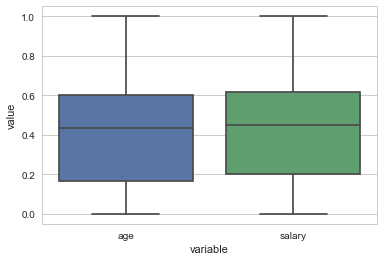

In [10]:
df = pd.melt(train.iloc[:,:2])
df.loc[:,"value"] = df.loc[:,"value"].astype(np.float)
sns.boxplot(df.iloc[:,0], df.iloc[:,1])

### Building kNN model with k = 1

In [11]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors = 1) 
model.fit(train.iloc[:,:2], train.iloc[:,2])
# with metric='minkowski' and p=2 (power param. for minkowski); it resembles Euclidean distance

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

### Estimated values

In [12]:
est = model.predict(train.iloc[:,:2])
est

array(['Level A', 'Level B', 'Level A', 'Level A', 'Level A', 'Level A',
       'Level B', 'Level B', 'Level B', 'Level A', 'Level B'],
      dtype=object)

In [13]:
from sklearn import metrics
actual = train.iloc[:,2].values.reshape(-1,1)
cm = metrics.confusion_matrix(actual, est, labels=pd.unique(train.iloc[:,2]))
cm

array([[6, 0],
       [0, 5]], dtype=int64)

(<matplotlib.figure.Figure at 0x1c9541f55f8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c953e0f080>)

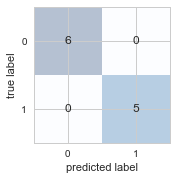

In [15]:
plot_confusion_matrix(cm)

## Accuracy of the model

### Training Accuracy

In [16]:
model.score(train.iloc[:,:2], train.iloc[:,2]) * 100

100.0

### Testing Accuracy

In [17]:
model.score(X_test, y_test) * 100

75.0

## Finding the best value of k

### Manually

In [18]:
for i in range(1,8):
    model = KNeighborsClassifier(n_neighbors = i)
    model.fit(train.iloc[:,:2], train.iloc[:,2])
    print("For k =", i, "Accuracy = ", model.score(train.iloc[:,:2], train.iloc[:,2]) * 100)

For k = 1 Accuracy =  100.0
For k = 2 Accuracy =  100.0
For k = 3 Accuracy =  100.0
For k = 4 Accuracy =  90.9090909090909
For k = 5 Accuracy =  100.0
For k = 6 Accuracy =  100.0
For k = 7 Accuracy =  100.0


### Cross-Validation

In [19]:
from sklearn.model_selection import cross_val_score
cv_scores = []
for k in range(1,8):
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, train.iloc[:,:2], train.iloc[:,2], cv=3, scoring='accuracy')
    cv_scores.append(scores.mean()*100)

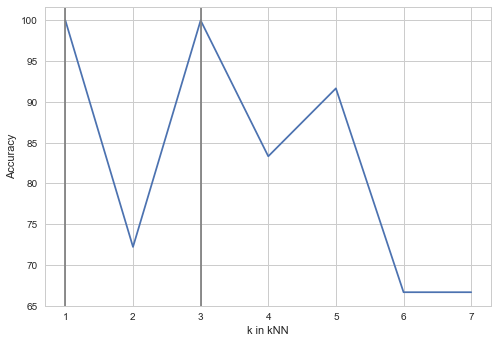

In [20]:
plt.plot(range(1,8),cv_scores)
plt.xlabel("k in kNN")
plt.ylabel("Accuracy")
plt.axvline(1, color='.5')
plt.axvline(3, color='.5')